# Exploratory Data Analysis (EDA)

## 1. About This Data

We're working with a Superstore dataset that tracks orders across regions, customer segments, and product categories. The data includes:

**Key columns:**
- **Sales** = Revenue per transaction (after discount is applied)
- **Quantity** = Units sold in each transaction
- **Discount** = The discount % given to the customer
- **Profit** = Net profit/loss for that transaction

The important thing: **Profit already includes everything** — product cost, shipping cost, and any operational expenses tied to that sale. We won't be able to break down individual cost components.

**Our job:** Understand where the business is losing money and why. Specifically, we need to determine if discounting is the culprit, or if there are structural problems with certain products/regions/segments.

Let's dig in.

## 2. Load and prepare data

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

In [11]:
df = pd.read_csv("data/Sample_Superstore.csv", encoding="latin-1")
print(f"Loaded {len(df):,} transactions")


Loaded 9,994 transactions


## 3. Data quality

In [12]:
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Shape: (9994, 21)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']


In [13]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   str    
 2   Order Date     9994 non-null   str    
 3   Ship Date      9994 non-null   str    
 4   Ship Mode      9994 non-null   str    
 5   Customer ID    9994 non-null   str    
 6   Customer Name  9994 non-null   str    
 7   Segment        9994 non-null   str    
 8   Country        9994 non-null   str    
 9   City           9994 non-null   str    
 10  State          9994 non-null   str    
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   str    
 13  Product ID     9994 non-null   str    
 14  Category       9994 non-null   str    
 15  Sub-Category   9994 non-null   str    
 16  Product Name   9994 non-null   str    
 17  Sales          9994 non-null   float64
 18  Quantity       9994

In [14]:
# Check for duplicates and missing values
print(f"Duplicate rows: {df.duplicated().sum()}")

missing = df.isnull().sum()
if missing.sum() == 0:
    print("Missing values: None")
else:
    print("Missing values:")
    print(missing[missing > 0])

Duplicate rows: 0
Missing values: None


In [15]:
# First few rows
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.00,41.91
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.00,219.58
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.00,6.87


## 4. Basic Transformations

In [30]:
# Convert dates and create key metrics
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])
df["Postal Code"] = df["Postal Code"].astype(str)

# Key metric: margin % (will use throughout)
df['margin_pct'] = (df['Profit'] / df['Sales']) * 100

# Implicit cost
df['cost'] = df['Sales'] - df['Profit']

## 5. Summary Statistics & Key Metrics

In [17]:
# Quick overview of the main metrics
numeric_cols = ["Sales", "Quantity", "Discount", "Profit"]
df[numeric_cols].describe()

,Sales,Quantity,Discount,Profit
count,9994.00,9994.00,9994.00,9994.00
mean,229.86,3.79,0.16,28.66
std,623.25,2.23,0.21,234.26
min,0.44,1.00,0.00,-6599.98
25%,17.28,2.00,0.00,1.73
50%,54.49,3.00,0.20,8.67
75%,209.94,5.00,0.20,29.36
max,22638.48,14.00,0.80,8399.98


**Quick observations:**
- Sales average $229, but median is only $54 (right-skewed, some very large orders)
- Quantity: Average 3.8 units per order, mostly 2-5 units
- Discount: Average 16% BUT median 20% — this tells us the distribution isn't smooth. There's likely a big cluster at 0% and another at 20%+
- Profit: Wide range ($-6,600 to $+8,400), and the mean ($28.66) is much higher than the median ($8.67), suggesting outlier losses are dragging down the average

The discount distribution especially is interesting — let's dig into that properly in the next notebook.

## 6. Profitability: The Big Question

**Starting point:** Is this business actually profitable? And if so, how thin are the margins?

In [18]:
# How much of the business is actually losing money?
negative_count = (df['Profit'] < 0).sum()
negative_pct = negative_count / len(df) * 100

print(f"Transactions with losses: {negative_count:,} ({negative_pct:.1f}%)")
print(f"Total loss from those transactions: ${df[df['Profit'] < 0]['Profit'].sum():,.2f}")

Transactions with losses: 1,871 (18.7%)
Total loss from those transactions: $-156,131.29


**Finding:** 18.7% of orders are losing money, totaling $156K in losses. The next question: **Do the profitable orders generate enough profit to offset these losses?**

In [19]:
# Get the overall picture
total_revenue = df['Sales'].sum()
total_profit = df['Profit'].sum()
overall_margin = (total_profit / total_revenue * 100)

print(f"Total Revenue:     ${total_revenue:,.2f}")
print(f"Total Profit:      ${total_profit:,.2f}")
print(f"Overall Margin:    {overall_margin:.1f}%")
print(f"\nProfit distribution:")
print(df['Profit'].describe())

Total Revenue:     $2,297,200.86
Total Profit:      $286,397.02
Overall Margin:    12.5%

Profit distribution:
count    9994.00
mean       28.66
std       234.26
min     -6599.98
25%         1.73
50%         8.67
75%        29.36
max      8399.98
Name: Profit, dtype: float64


Profit distribution: Mean $28.66, Median $8.67 (mean >> median = outliers dragging things)

**First take:** The business is profitable overall, and 12.5% margin is actually solid for retail (typically 5-10% is the target).

But here's the problem: If the overall margin is 12.5%, but 18.7% of orders are losing money, that means the profitable orders are carrying a lot of weight. The winners are subsidizing the losers.

**The real question:** Which orders are winners and which are losers? Is it random, or is there a pattern? Are certain products/regions/discounts systematically destroying value?

In [20]:
# Margin % across all transactions
print("Margin % Statistics:")
print(df['margin_pct'].describe())
print(f"\nTransactions with negative margin: {(df['margin_pct'] < 0).sum():,}")

Margin % Statistics:
count   9994.00
mean      12.03
std       46.68
min     -275.00
25%        7.50
50%       27.00
75%       36.25
max       50.00
Name: margin_pct, dtype: float64

Transactions with negative margin: 1,871



**What this tells us:** The median margin (27%) is healthy, but the mean (12%) is much lower. This gap is a red flag—it means a small number of transactions are losing massive amounts of money.

The -275% outlier is especially concerning: that's a transaction where the loss is 2.75x larger than the original sale. These extreme losses are what's dragging down the average.

**The story:** This isn't a "most orders are mediocre" situation. This is "most orders are ok, but a concentrated set of orders are hemorrhaging money." We need to identify which orders (which products, categories, segments) are the culprits.

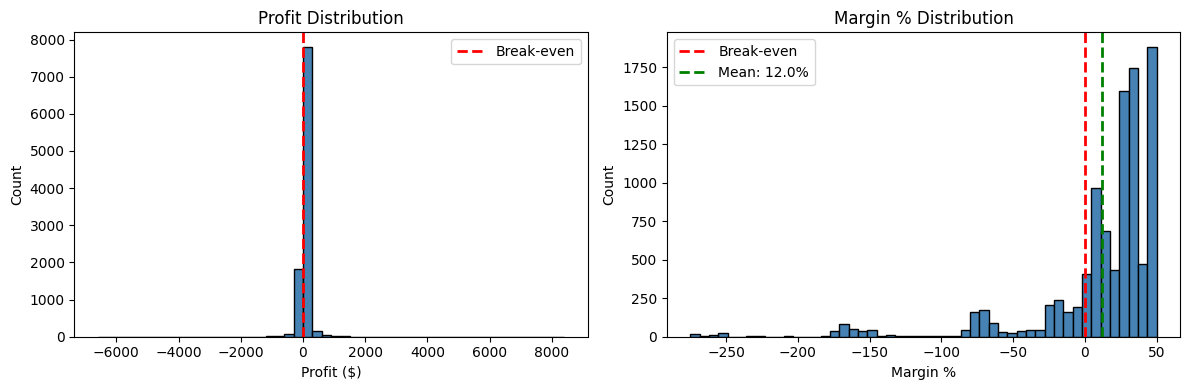

In [21]:
# Visual check of profit and margin distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['Profit'], bins=50, color='steelblue', edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
axes[0].set_title('Profit Distribution')
axes[0].set_xlabel('Profit ($)')
axes[0].set_ylabel('Count')
axes[0].legend()

axes[1].hist(df['margin_pct'], bins=50, color='steelblue', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
axes[1].axvline(df['margin_pct'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {df["margin_pct"].mean():.1f}%')
axes[1].set_title('Margin % Distribution')
axes[1].set_xlabel('Margin %')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

**What we see in these distributions:**

The Profit chart shows most orders cluster around break-even, with a long tail of profitable orders and another tail of losses. The Margin % chart tells a clearer story: most transactions land in the 20-50% margin range, which is healthy. But there's a noticeable left tail of negative margins stretching down to -275%.

**What this means:** It's not that half the orders are winners and half are losers (that would be bimodal). Instead, most orders are profitable, but a concentrated group—roughly 19% of transactions—are systematically unprofitable. Those outliers are small in count but massive in impact because they're EXTREME losses.

**The real question:** Why does that 19% exist? Is it a product issue, a pricing issue, or something else? That's what we need to dig into next.

## 7. Breakdown by Category, Segment & Region

Let's see which dimensions are driving the losses.

In [22]:
# Quick look at structure
print("Data composition:")
print(f"  Countries: {df['Country'].nunique()} ({df['Country'].unique().tolist()})")
print(f"  Regions: {df['Region'].nunique()} ({df['Region'].unique().tolist()})")
print(f"  Segments: {df['Segment'].nunique()} ({df['Segment'].unique().tolist()})")
print(f"  Categories: {df['Category'].nunique()} ({df['Category'].unique().tolist()})")
print(f"  Sub-Categories: {df['Sub-Category'].nunique()}")

Data composition:
  Countries: 1 (['United States'])
  Regions: 4 (['South', 'West', 'Central', 'East'])
  Segments: 3 (['Consumer', 'Corporate', 'Home Office'])
  Categories: 3 (['Furniture', 'Office Supplies', 'Technology'])
  Sub-Categories: 17


In [23]:
# Where is the profit coming from? And where are the losses?
total_profit = df['Profit'].sum()

print("\nProfit by Category:")
cat_profit = df.groupby('Category')['Profit'].agg(['sum', 'count', 'mean']).round(2)
cat_profit['pct_of_total'] = (cat_profit['sum'] / total_profit * 100).round(1)
cat_profit.columns = ['Total', 'Count', 'Avg', '%']
print(cat_profit)


Profit by Category:
                    Total  Count   Avg     %
Category                                    
Furniture        18451.27   2121  8.70  6.40
Office Supplies 122490.80   6026 20.33 42.80
Technology      145454.95   1847 78.75 50.80


In [24]:
print("\nProfit by Segment:")
seg_profit = df.groupby('Segment')['Profit'].agg(['sum', 'count', 'mean']).round(2)
seg_profit['pct_of_total'] = (seg_profit['sum'] / total_profit * 100).round(1)
seg_profit.columns = ['Total', 'Count', 'Avg', '%']
print(seg_profit)


Profit by Segment:
                Total  Count   Avg     %
Segment                                 
Consumer    134119.21   5191 25.84 46.80
Corporate    91979.13   3020 30.46 32.10
Home Office  60298.68   1783 33.82 21.10


In [25]:
print("\nProfit by Region:")
reg_profit = df.groupby('Region')['Profit'].agg(['sum', 'count', 'mean']).round(2)
reg_profit['pct_of_total'] = (reg_profit['sum'] / total_profit * 100).round(1)
reg_profit.columns = ['Total', 'Count', 'Avg', '%']
print(reg_profit)


Profit by Region:
            Total  Count   Avg     %
Region                              
Central  39706.36   2323 17.09 13.90
East     91522.78   2848 32.14 32.00
South    46749.43   1620 28.86 16.30
West    108418.45   3203 33.85 37.90


**The pattern emerging:**

Technology generates 51% of profit from only 18.5% of orders ($78.75/order avg).
Furniture generates only 6.4% of profit from 21.2% of orders ($8.70/order avg).

This gap is significant. If Furniture orders are structurally weak AND if they're also receiving heavy discounts, that combo would explain the extreme losses we saw earlier.

Same logic applies to segments: Home Office generates 33% more profit per order than Consumer. If discounts are distributed unevenly—hitting weak categories harder—that would concentrate losses exactly where we're seeing them.

**Next step:** We need to verify this. Do Furniture orders get more discounts? Does Consumer segment get more discounts? That's the real question for the discount analysis.

In [31]:
# Quick check: average discount by category
print("Average discount by category:")
discount_by_cat = df.groupby('Category').agg({
    'Discount': 'mean',
    'Profit': 'mean',
    'Sales': 'count'
}).round(3)
discount_by_cat.columns = ['Avg Discount', 'Avg Profit', 'Count']
print(discount_by_cat)

Average discount by category:
                 Avg Discount  Avg Profit  Count
Category                                        
Furniture                0.17        8.70   2121
Office Supplies          0.16       20.33   6026
Technology               0.13       78.75   1847


In [32]:
# Check for outliers in discount
print("\nDiscount distribution:")
print(df['Discount'].describe())

print("\nDiscount by Sub-Category (avg):") 
discount_by_sub = df.groupby('Sub-Category')['Discount'].agg(['mean', 'count']).round(3)
discount_by_sub.columns = ['Avg Discount', 'Count']
discount_by_sub = discount_by_sub.sort_values('Avg Discount', ascending=False)
print(discount_by_sub.head(10))


Discount distribution:
count   9994.00
mean       0.16
std        0.21
min        0.00
25%        0.00
50%        0.20
75%        0.20
max        0.80
Name: Discount, dtype: float64

Discount by Sub-Category (avg):
              Avg Discount  Count
Sub-Category                     
Binders               0.37   1523
Machines              0.31    115
Tables                0.26    319
Bookcases             0.21    228
Chairs                0.17    617
Appliances            0.17    466
Copiers               0.16     68
Phones                0.15    889
Furnishings           0.14    957
Fasteners             0.08    217


#### Verifying: Where Are the Aggressive Discounts?

**Category-level view (what we checked before):**
Technology gets 13% discount but makes $78.75 profit/order.
Furniture gets 17% discount but only makes $8.70 profit/order.
→ Conclusion: Category-level discount differences don't explain the profit gap.

**But here's what we MISSED—the sub-category level tells a completely different story:**

Binders: 37% avg discount, 1,523 transactions
Machines: 31% avg discount, 115 transactions  
Tables: 26% avg discount, 319 transactions
Copiers: 16% avg discount, 68 transactions
Fasteners: 8% avg discount, 217 transactions

**This is the REAL problem.** Binders and Machines aren't just structurally weak—they're also being discounted AGGRESSIVELY (30%+ on average). That's a dangerous combo.

**The specificity matters:**
- Binders at 37% discount is NOT the same as "Office Supplies at 16% discount"
- Machines at 31% discount is NOT the same as "Technology at 13% discount"

These subcategories are getting hit with 2-3x higher discounts than their parent categories. When a weak product (low margin) meets aggressive discounting (30%+), you get catastrophic losses.

**Prediction:** When we look at the worst 10 transactions, we should see:
1. Binders and Machines dominating the list
2. Discounts in the 30-80% range
3. Negative margins ranging from -50% to -150%+

## 8. Notable Transactions & Outliers

Let's look at the extremes—what does a winning order look like vs. a losing one?

In [26]:
# See the worst performers
print("Biggest losses (worst 10):")
worst = df.nsmallest(10, 'Profit')[['Order ID', 'Category', 'Sub-Category', 'Sales', 'Discount', 'Profit', 'margin_pct']]
print(worst.to_string())

Biggest losses (worst 10):
            Order ID         Category Sub-Category    Sales  Discount   Profit  margin_pct
7772  CA-2016-108196       Technology     Machines  4499.98      0.70 -6599.98     -146.67
683   US-2017-168116       Technology     Machines  7999.98      0.50 -3839.99      -48.00
9774  CA-2014-169019  Office Supplies      Binders  2177.58      0.80 -3701.89     -170.00
3011  CA-2017-134845       Technology     Machines  2549.99      0.70 -3399.98     -133.33
4991  US-2017-122714  Office Supplies      Binders  1889.99      0.80 -2929.48     -155.00
3151  CA-2015-147830       Technology     Machines  1799.99      0.70 -2639.99     -146.67
5310  CA-2017-131254  Office Supplies      Binders  1525.19      0.80 -2287.78     -150.00
9639  CA-2015-116638        Furniture       Tables  4297.64      0.40 -1862.31      -43.33
1199  CA-2016-130946  Office Supplies      Binders  1088.79      0.80 -1850.95     -170.00
2697  CA-2014-145317       Technology     Machines 22638.48    

**Notice:** Look at the Discount column for these losing orders. It's worth checking if high discounts are the common pattern.

In [27]:
# See the best performers
print("\nBiggest gains (best 10):")
best = df.nlargest(10, 'Profit')[['Order ID', 'Category', 'Sub-Category', 'Sales', 'Discount', 'Profit', 'margin_pct']]
print(best.to_string())


Biggest gains (best 10):
            Order ID         Category Sub-Category    Sales  Discount  Profit  margin_pct
6826  CA-2016-118689       Technology      Copiers 17499.95      0.00 8399.98       48.00
8153  CA-2017-140151       Technology      Copiers 13999.96      0.00 6719.98       48.00
4190  CA-2017-166709       Technology      Copiers 10499.97      0.00 5039.99       48.00
9039  CA-2016-117121  Office Supplies      Binders  9892.74      0.00 4946.37       50.00
4098  CA-2014-116904  Office Supplies      Binders  9449.95      0.00 4630.48       49.00
2623  CA-2017-127180       Technology      Copiers 11199.97      0.20 3919.99       35.00
509   CA-2015-145352  Office Supplies      Binders  6354.95      0.00 3177.47       50.00
8488  CA-2016-158841       Technology     Machines  8749.95      0.00 2799.98       32.00
7666  US-2016-140158       Technology      Copiers  5399.91      0.00 2591.96       48.00
6520  CA-2017-138289  Office Supplies      Binders  5443.96      0.00 2504

In [33]:
# Quick verification of the prediction
print("\nVerifying the prediction:")
print("\nWorst 10 breakdown:")
worst_10 = df.nsmallest(10, 'Profit')
print(worst_10[['Sub-Category', 'Discount']].groupby('Sub-Category').agg(['count', 'mean']).round(2))

print("\nBest 10 breakdown:")
best_10 = df.nlargest(10, 'Profit')
print(best_10[['Sub-Category', 'Discount']].groupby('Sub-Category').agg(['count', 'mean']).round(2))


Verifying the prediction:

Worst 10 breakdown:
             Discount     
                count mean
Sub-Category              
Binders             4 0.80
Machines            5 0.62
Tables              1 0.40

Best 10 breakdown:
             Discount     
                count mean
Sub-Category              
Binders             4 0.00
Copiers             5 0.04
Machines            1 0.00


In [28]:
# Check for outliers in margin using IQR method
Q1 = df['margin_pct'].quantile(0.25)
Q3 = df['margin_pct'].quantile(0.75)
IQR = Q3 - Q1

outlier_low = Q1 - 1.5 * IQR
outlier_high = Q3 + 1.5 * IQR

print(f"Margin % outliers (IQR method):")
print(f"  Normal range: {outlier_low:.1f}% to {outlier_high:.1f}%")
print(f"  Extreme low (below {outlier_low:.1f}%): {(df['margin_pct'] < outlier_low).sum()} transactions")
print(f"  Extreme high (above {outlier_high:.1f}%): {(df['margin_pct'] > outlier_high).sum()} transactions")

Margin % outliers (IQR method):
  Normal range: -35.6% to 79.4%
  Extreme low (below -35.6%): 952 transactions
  Extreme high (above 79.4%): 0 transactions


### Notable Transactions: Where the money goes

**The 10 biggest losses:**

Machines (5 of 10) and Binders (4 of 10) dominate the loss column, with aggressive discounts:
- Machines: 62% avg discount, losses ranging from -$1.8K to -$6.6K
- Binders: 80% avg discount, losses ranging from -$1.8K to -$3.7K
- Tables: 1 transaction with 40% discount

What's striking: A single Machines order with a 70% discount lost $6,600. Another with a 50% discount lost $3,840. These aren't small mistakes—they're transactions where the discount is so aggressive that the product becomes deeply unprofitable.

**The 10 biggest gains:**

Copiers (5 of 10) are the star—they're hitting 48% margins with 0-4% average discount. Binders (4 of 10) also appear here with zero discount and 46-50% margins. Machines only appear once.

The contrast is brutal: the same sub-category (Binders) appears in both the worst AND best lists, separated entirely by discount level.

**The disconnect:**
- Binders with 80% discount = -$1,850 to -$3,700 losses
- Binders with 0% discount = +$2,504 to +$4,946 profit
- Machines with 62% avg discount = -$1.8K to -$6.6K losses
- Machines with 0% discount = +$2,800 profit

Same products, different discount strategies, wildly different outcomes.

**Outliers (IQR analysis):**
952 transactions fall into extreme loss territory (below -35.6% margin). That's 9.5% of all orders—roughly half of the 18.7% losing money. These extreme cases are where the real damage happens.

**The story so far:** It's not that Machines or Binders are inherently bad. It's that when you give massive discounts (60-80%) to products with thin margins, you create catastrophic losses. Copiers, in contrast, thrive without discounts because they have strong baseline margins (48%+).

### Summary: What We Know So Far

From this EDA, we've established:

1. **Solid overall margin, but concentrated losses:** 12.5% profit margin is healthy for retail. But 18.7% of transactions are losing money—meaning the profitable orders are carrying the load.

2. **Discounts correlate with losses:** The worst orders have 62-80% discounts. The best orders have 0-4% discounts. This isn't a coincidence—it's systematic.

3. **Structural weakness in certain sub-categories:** Machines and Binders are disaster zones when discounted (62% and 80% avg). But the same Binders with NO discount? They're among the top 10 best-performing transactions. Copiers thrive across the board because they have strong baseline margins (48%+).

4. **Discount threshold matters more than category:** Technology has higher baseline profitability, but even Technology products (Machines) blow up with 62% avg discounts in the worst 10. Office Supplies (Binders) can generate $4,946 profit OR lose $3,701, depending entirely on discount. It's not about the category—it's about whether the product can absorb the discount.

**Next steps:**
- 02_discount_analysis.ipynb → Quantify exactly the "discount threshold" for each product—how much discount can each sub-category absorb before it becomes unprofitable?
- 03_profit_analysis.ipynb → Identify which products are structurally broken vs. just poorly discounted

In [29]:
# Save for next notebooks
df.to_csv('sample_superstore_processed.csv', index=False)
print("Data saved.")

Data saved.
